<a href="https://colab.research.google.com/github/KhawajaMuddassar/object_detection-and-image-classification/blob/main/training_faster_r_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Advance Object Detection**

Faster R-CNN, YOLO, and Single Shot Detector (SSD) are recognized as advanced techniques in the field of object detection. These methods leverage deep learning architectures to improve accuracy and efficiency in identifying objects within images. **Faster R-CNN** employs a region proposal network to enhance detection speed and precision, while **YOLO (You Only Look Once)** processes images in a single pass, making it particularly suitable for real-time applications. **Single Shot Detector (SSD)**, on the other hand, combines the strengths of both approaches by using a single deep neural network to predict bounding boxes and class scores simultaneously, achieving a balance between speed and accuracy. Collectively, these techniques represent significant advancements in the ability to analyze and interpret visual data across various domains.

**Componants of Modren Object Detection Algorithms:**

R-CNN and Fast R-CNN have a couple of downsides: they use two separate networks—one to find areas that might have objects and another to fine-tune the bounding boxes around those objects. Plus, each model needs to process as many passes as there are region proposals, which can be slow. Nowadays, object detection algorithms are designed to train a single neural network that can detect all objects in just one pass. Here are the different components of a typical modern object detection algorithm:

* Anchor boxes
* Region proposal network (RPN)
* Region of interest (RoI) pooling


**Anchor boxes** are predefined bounding boxes with varying sizes and aspect ratios that facilitate object localization in advanced detection algorithms.Typically, this is obtained by employing K-means clustering on top of the ground-truth bounding boxes of objects present in images. By providing reference points, they enable the model to predict and refine the positions and dimensions of objects more accurately, allowing for improved alignment with the features extracted from the input image.

**how to leverage them in the process:**
1. Slide each anchor box over an image from top left to bottom right.
2. The anchor box that has a high intersection over union (IoU) with the object will have a label
that mentions that it contains an object, and the others will be labeled 0.

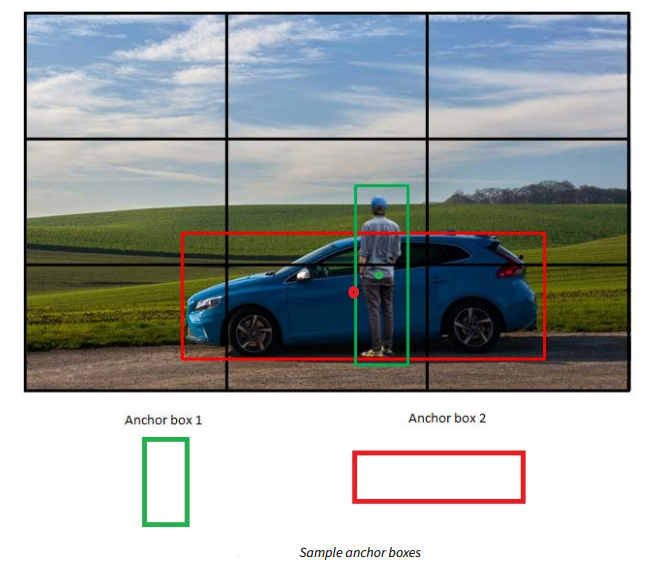

**Region Proposal Network (RPN)** is a key component in advanced object detection algorithms that generates potential bounding box proposals for objects within an image. It employs a convolutional neural network to efficiently scan the feature map, predicting object locations and objectness scores, which significantly streamlines the process of identifying regions of interest compared to traditional methods.

SelectiveSearch gives us a region candidate based on a set of computations on top of pixel values. However, an RPN generates region candidates based on the anchor boxes and the strides with which anchor boxes are slid over the image.While region proposal generation based on selectivesearch is done outside of the neural network,we can build an RPN that is a part of the object detection network.This way, we have a single model to identify regions, identify classes of objects in an image, and identify their corresponding bounding box locations.

In summary, a Region Proposal Network (RPN) trains a model to identify region proposals that are likely to contain objects by following these steps:

* It slides anchor boxes of various sizes and aspect ratios across the image to generate crops.
* It calculates the Intersection over Union (IoU) between the ground-truth bounding boxes and the generated crops.
* It organizes the training dataset so that crops with an IoU greater than a specified threshold are labeled as containing objects, while those with an IoU below that threshold are not.
* The model is then trained to pinpoint regions that are likely to contain objects.
* Finally, non-max suppression is applied to select the candidate region with the highest probability of containing an object, removing others that overlap significantly with it.


**Classification and Regression Tasks**
So far, we've covered in above steps to identify objects and adjust bounding boxes:

* First, we locate the regions that contain objects.
* Next, we make sure all the feature maps from those regions are the same size using RoI pooling

However, there are a couple of issues with these steps:

* The region proposals might not fit snugly around the object (we used an IoU threshold of >0.5 in the RPN).
* While we can tell if a region has an object, we haven't determined what type(Class) of object it is.

In this pivotal segment, we'll tackle these two challenges. We'll take the uniformly shaped feature maps we created earlier and pass them through a network. Our goal is for the network to predict both the class of the object in each region and the adjustments needed to make the bounding box fit as closely as possible around the object in the image.

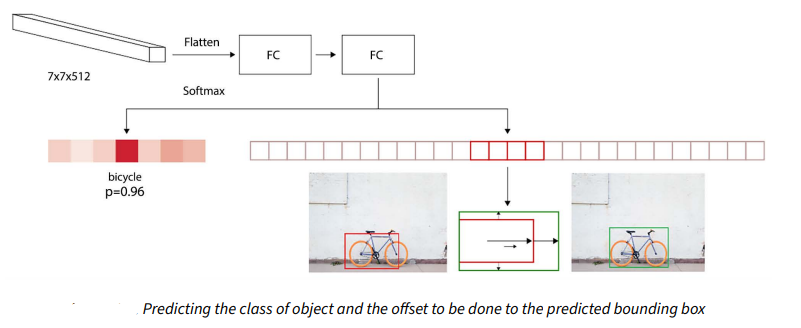

In the preceding diagram, we are utilizing the output from RoI pooling as input (with a shape of 7 x 7 x 512), flattening it, and connecting it to a dense layer to predict two key aspects:

* The class of the object within the region
* The offsets needed for the predicted bounding boxes to optimize the IoU with the ground truth

As a result, if there are 20 classes in the dataset, the output from the neural network will comprise a total of 25 outputs—21 classes (including the background class) along with 4 offsets to adjust the height, width, and two center coordinates of the bounding box.

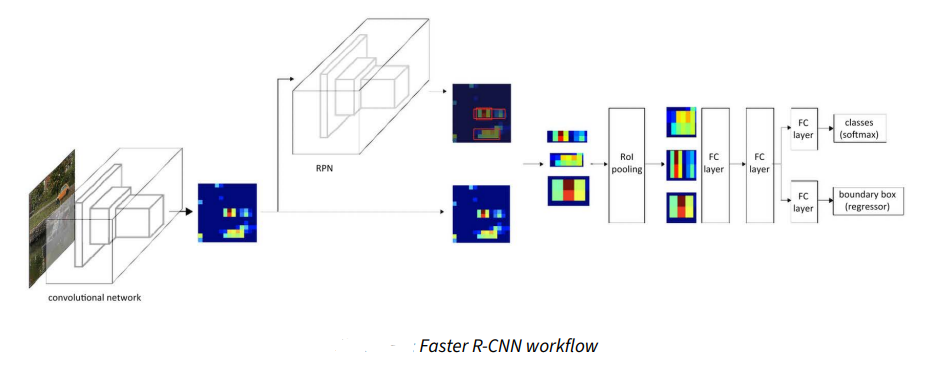

# **Training Faster R-CNN on Custom Dataset**

In [ ]:
!pip install -qU torch-snippets
import torch, glob
import torchvision
from torch_snippets import *
from torch_snippets.torch_loader import DataLoader, Dataset,Report
from sklearn.model_selection import train_test_split
from google.colab import files
from  torchvision.models.detection.faster_rcnn import FastRCNNPredictor
files.upload()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip
!rm open-images-bus-trucks.zip

root_folder = 'images/images'
data = df = pd.read_csv('df.csv')
data.head(3)

Saving kaggle.json to kaggle.json
kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks/versions/
License(s): unknown
100% 365M/367M [00:19<00:00, 22.3MB/s]
100% 367M/367M [00:19<00:00, 19.6MB/s]


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739


In [ ]:

# Define Indices for labels and targets
label2target = {l:t+1 for t,l in enumerate(data['LabelName'].unique())} # Create Dictionary for label2target keyvalue pairs of classes
label2target['background'] =0
target2label = {t:l for l,t in label2target.items()} # Reverse mapping to reverse dictionary order
background_class = label2target['background'] # just to add entry backgroound class manually with value 0
num_classes = len(label2target)

# Define image preprocessing funciton
def preprocess(image):
    image = torch.tensor(image).permute(2,0,1) # Permute will place channel in proper position by rearranges the dimensions of the tensor (channels, height, width)
    return image.to(device).float() # move tensor to device then covert it float and return it

# Define Dataset class
class OpenSet(Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=root_folder):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID[:200].unique() # Limit the dataset to only 200 images due to limited computatinal resources, you can remove it
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        # torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch))
    def __len__(self):
        return len(self.image_infos)

# Generate Training and validation datasets and dataloaders

# Data Split
train_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=1) # Get the first 100 unique ImageIDs
train_df , val_df = df[df['ImageID'].isin(train_ids)], df[df['ImageID'].isin(val_ids)]

# Datasets
train_dataset = OpenSet(train_df)
test_dataset = OpenSet(val_df)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=train_dataset.collate_fn, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=4, collate_fn=test_dataset.collate_fn, drop_last=True)

# Define Model
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Define function to train on batchs and calculate loss on validation data
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 144MB/s]


EPOCH: 1.000  trn_loss: 0.435  val_loc_loss: 0.117  val_objectness_loss: 0.024  val_loss: 0.304  val_rpn_box_reg_loss: 0.008  trn_rpn_box_reg_loss: 0.014  trn_loc_loss: 0.204  trn_regr_loss: 0.178  trn_objectness_loss: 0.038  val_regr_loss: 0.154  (37.83s - 151.33s remaining)
EPOCH: 2.000  trn_loss: 0.248  val_loc_loss: 0.107  val_objectness_loss: 0.014  val_loss: 0.247  val_rpn_box_reg_loss: 0.006  trn_rpn_box_reg_loss: 0.011  trn_loc_loss: 0.093  trn_regr_loss: 0.131  trn_objectness_loss: 0.013  val_regr_loss: 0.120  (74.55s - 111.83s remaining)
EPOCH: 3.000  trn_loss: 0.181  val_loc_loss: 0.090  val_objectness_loss: 0.014  val_loss: 0.222  val_rpn_box_reg_loss: 0.006  trn_rpn_box_reg_loss: 0.009  trn_loc_loss: 0.068  trn_regr_loss: 0.099  trn_objectness_loss: 0.005  val_regr_loss: 0.112  (115.08s - 76.72s remaining)
EPOCH: 4.000  trn_loss: 0.139  val_loc_loss: 0.089  val_objectness_loss: 0.017  val_loss: 0.217  val_rpn_box_reg_loss: 0.006  trn_rpn_box_reg_loss: 0.008  trn_loc_loss: 

100%|██████████| 106/106 [00:00<00:00, 13012.45it/s]


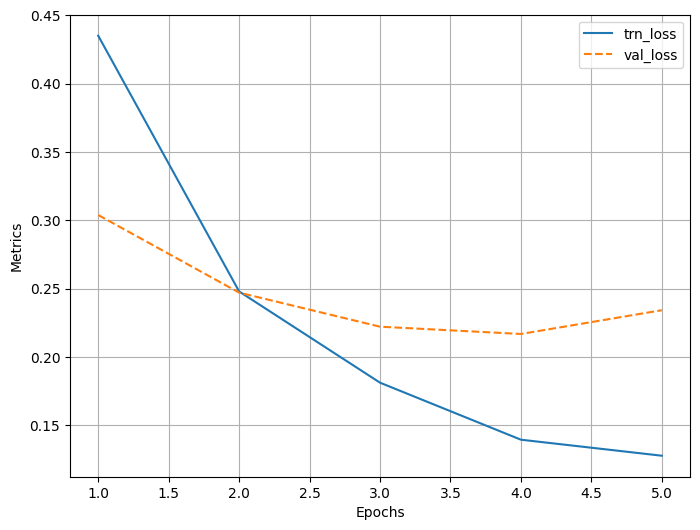

In [ ]:
# Instanctiate Model
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(val_loader)
    for ix,inputs in enumerate(val_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)
log.plot_epochs(['trn_loss','val_loss'])

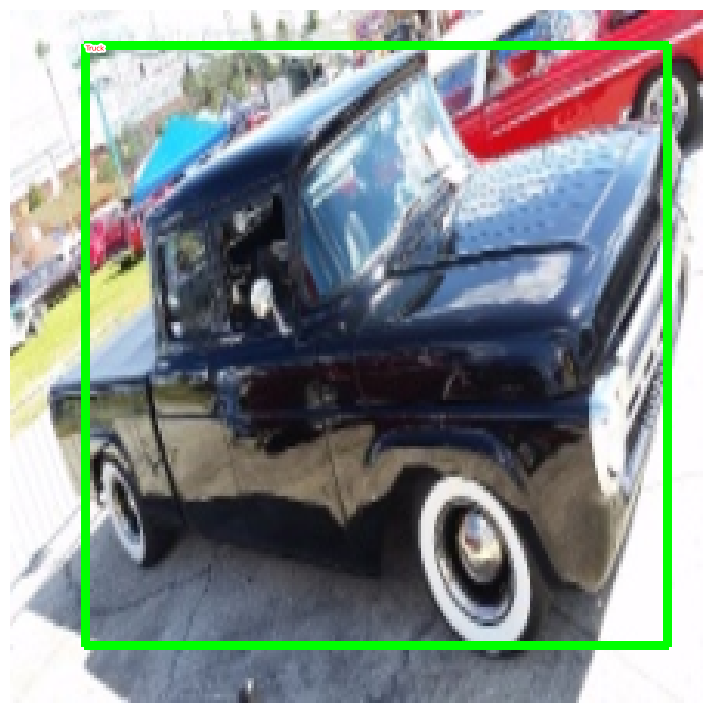

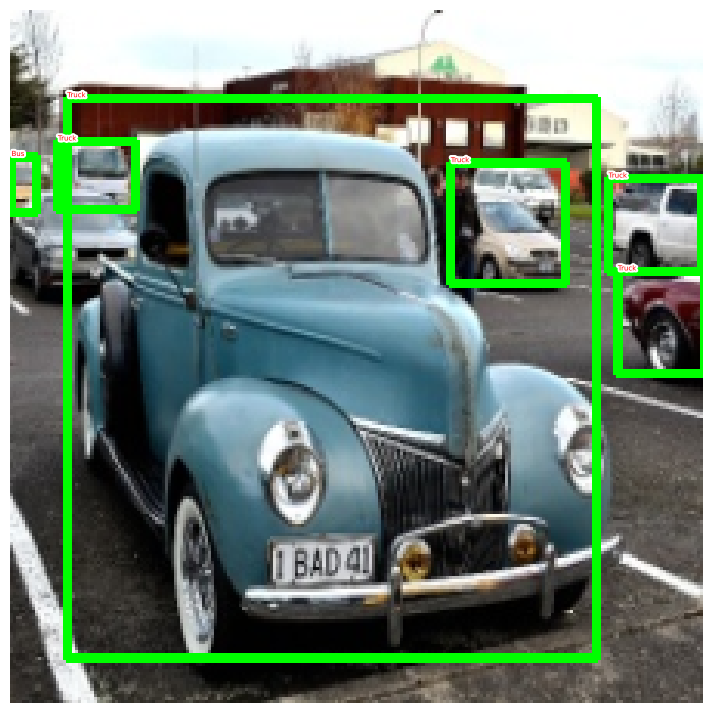

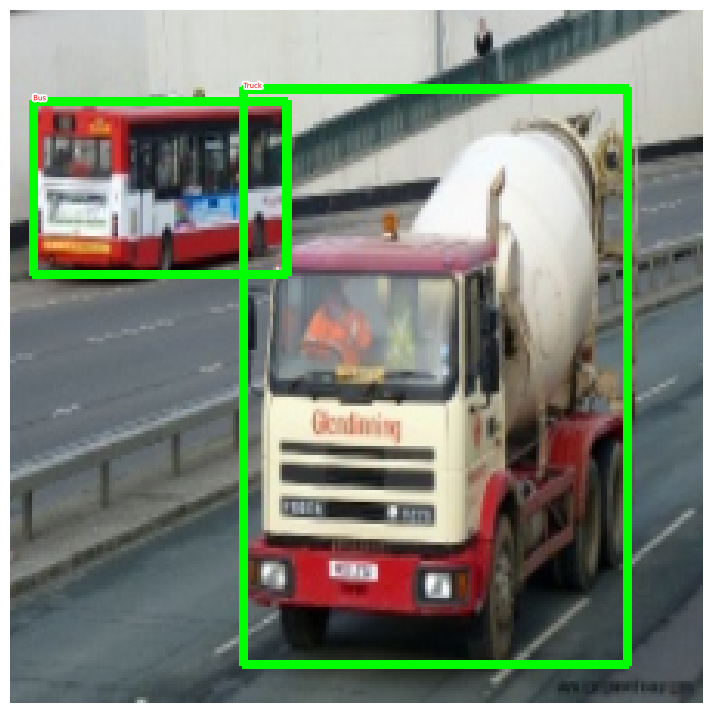

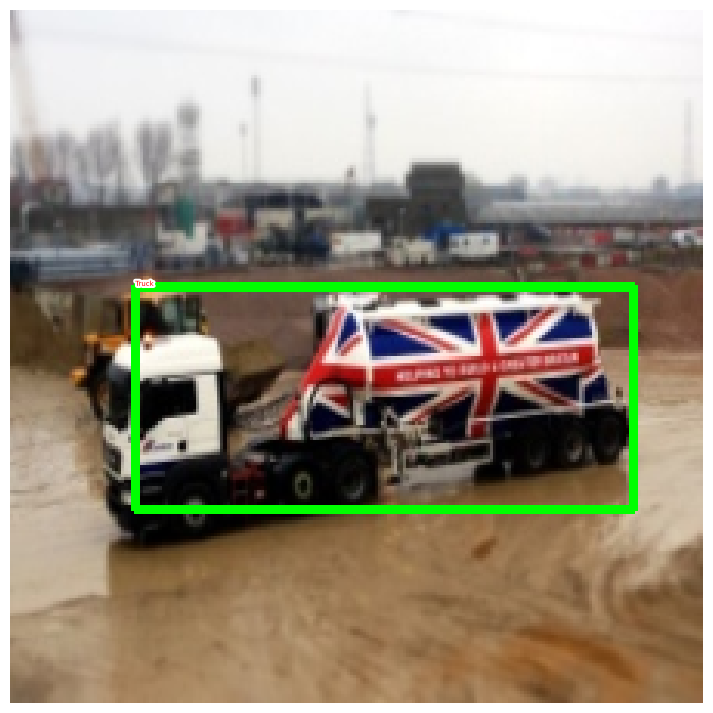

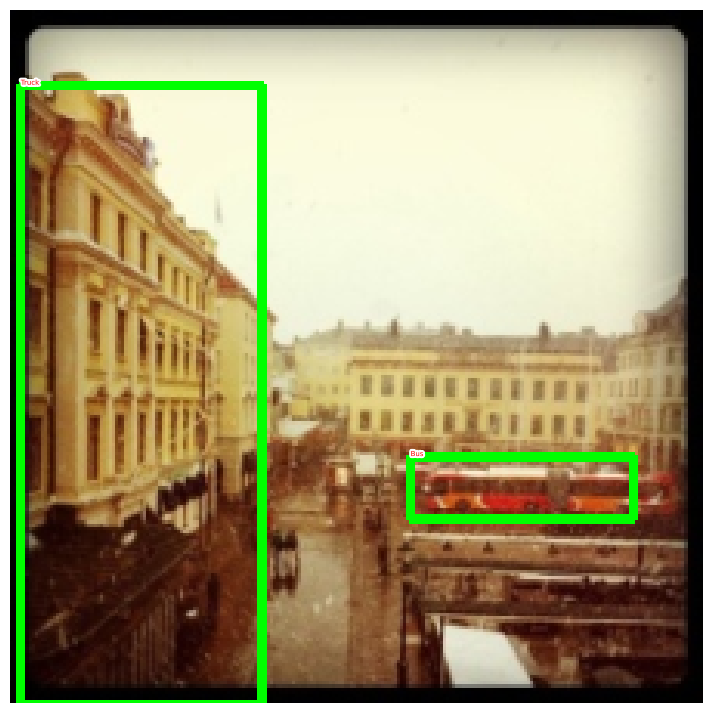

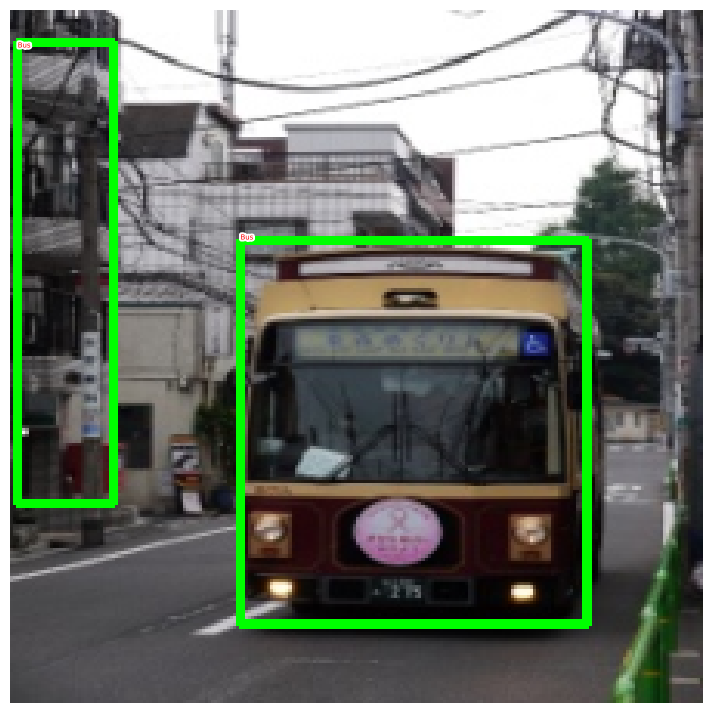

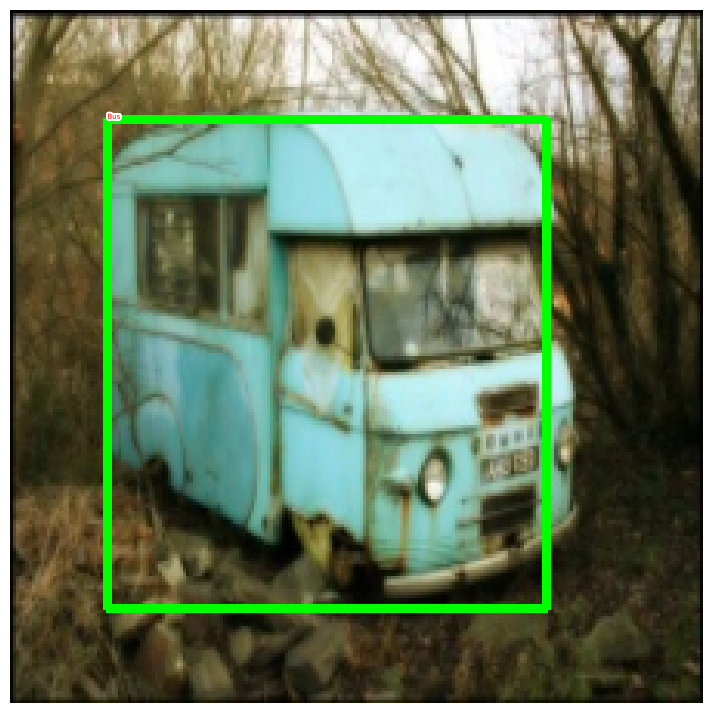

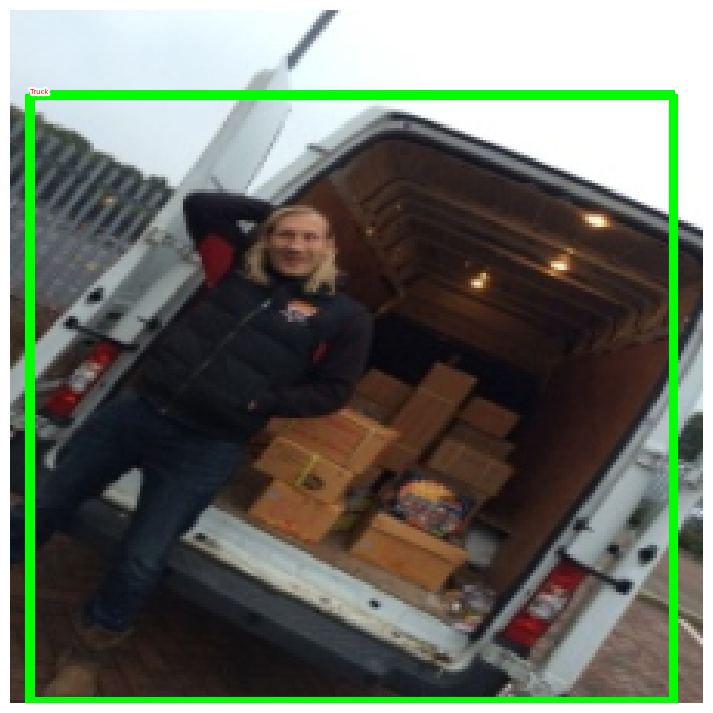

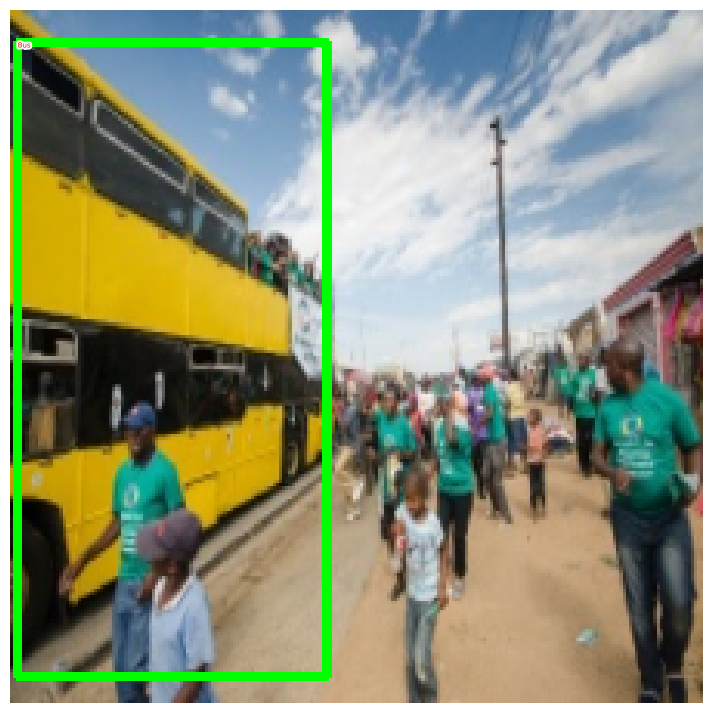

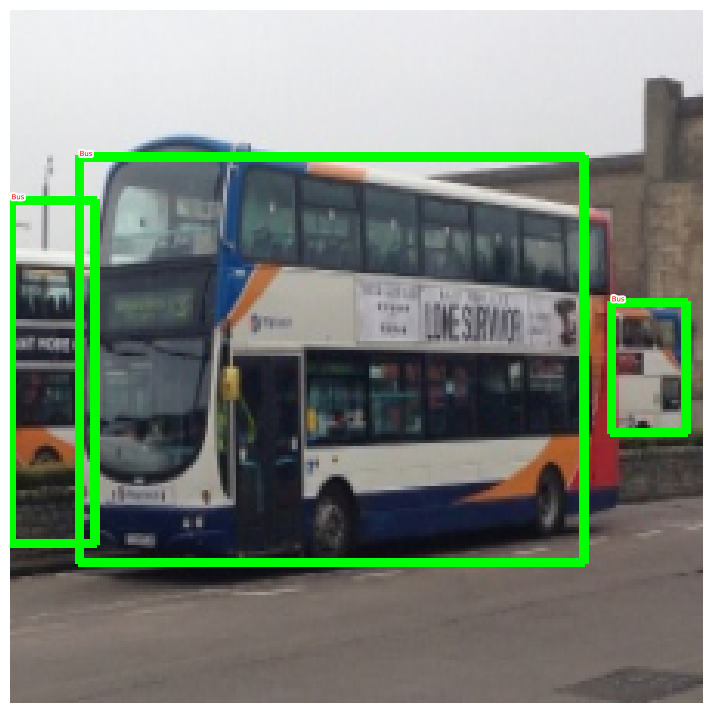

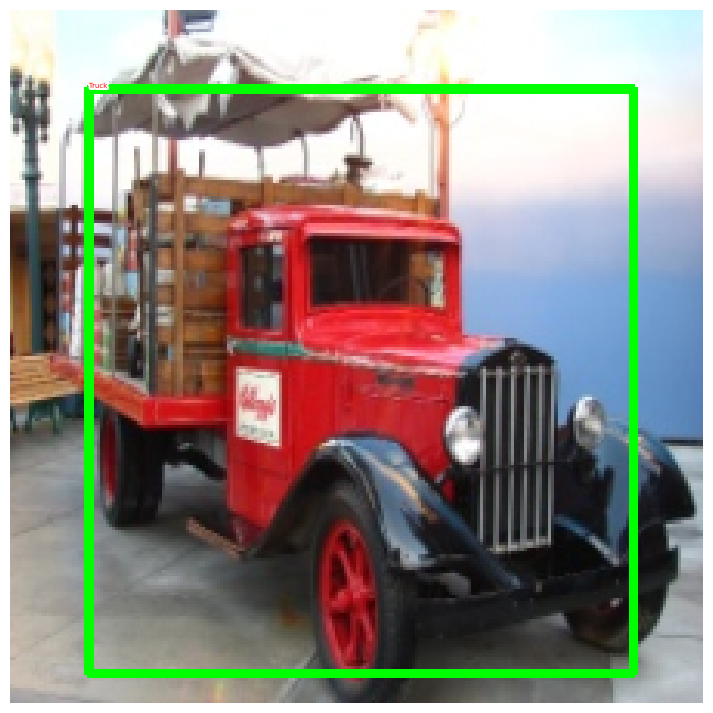

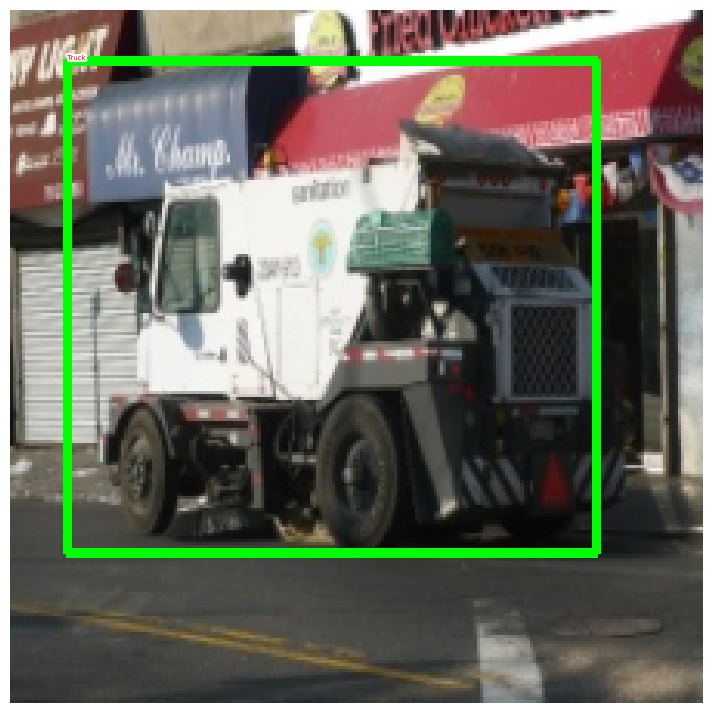

In [ ]:
# Make prediction on new images
from torchvision.ops import nms
def decode_output(output):# takes the model's output and provides the list of boxes, scores, and classes after non-max suppression
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

# Fetch the predictions of the boxes and classes on test images
model.eval()
for ix, (images, targets) in enumerate(val_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=9)